In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *
from python.optimizations import (weight_norm, VariationalDropout, 
    VariationalHidDropout, WeightDrop, embedded_dropout)

## Global settings

In [2]:
batch_size = 1 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Torch version: {}'.format(torch.__version__))
print('Device: %s' % (device))

Torch version: 1.0.0
Device: cpu


## Load data

In [3]:
data = pd.read_csv('../data/data.csv', index_col=0)

## Create 'Dataset' and 'DataLoader' 

In [4]:
class Data(Dataset):
    def __init__(self, data):
        self.data = data
        self.data.index = np.arange(len(self.data))
 
    def __getitem__(self, i): 
        return get_input(self.data.at[i,'file']), get_labels(self.data.at[i,'file'])

    def __len__(self):
        return len(self.data)
    
     
# merges a list of samples to form a mini-batch
def collate_fn(batch):
    features, labels = zip(*batch)
    
    features = pad_sequence(features, batch_first=True)
    
    labels = pad_sequence(labels, batch_first=True)
    
    return features, labels

## Select data and split it into training and validation data

In [5]:
# just ballroom 
ballroom = data[data['data_set'] == 1]

np.random.seed(1111)

train_valid_ratio = 0.9

train_indices = np.sort(np.random.choice(ballroom['idx'], int(len(ballroom)*train_valid_ratio), replace=False))
valid_indices = np.sort(np.array(list(set(np.arange(len(ballroom))) - set(train_indices))))

train_set = Data(ballroom.iloc[train_indices])
valid_set = Data(ballroom.iloc[valid_indices])

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, 
                         drop_last=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset=valid_set, batch_size=len(valid_set), collate_fn=collate_fn)

## LSTM model

In [42]:
# LSTM

class ModelBoeck(nn.Module):
    def __init__(self):
        super(ModelBoeck, self).__init__()
        
        # Model parameters
        self.input_size = 120
        self.output_size = 2
        self.num_layers = 3
        self.hidden_size = 25     
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1
        
        # Recurrent layer 
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, 
                            bidirectional=self.bidirectional,
                            batch_first=True)
        
        # Read out layer
        self.fc = nn.Linear(self.num_directions * self.hidden_size, self.output_size)       
        
    def forward(self, x):         
        lstm_out, _ = self.lstm(x)         
        fc_out = self.fc(lstm_out)
        y = F.log_softmax(fc_out, dim=2)
        return torch.transpose(y, 1, 2)

In [43]:
model = ModelBoeck().to(device)

## TCN model

In [41]:
# TCN

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
    
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x.transpose(1, 2)).transpose(1, 2)
        output = self.linear(output).double()        
        output = F.log_softmax(output, dim=2).transpose(1, 2)
        return output
    

In [42]:
input_size = 120
output_size = 2
nhid = 100
levels = 6
n_channels = [nhid] * levels
kernel_size = 5
dropout = 0.25

model = TCN(input_size, output_size, n_channels, kernel_size, dropout=dropout).to(device)

print('Number of learnable Parameters: {}'.format(count_parameters(model)))

Number of learnable Parameters: 624702


## Trellis Net

In [35]:
# Trellis Net

class WeightShareConv1d(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_out, kernel_size, dropouth=0.0):
        """
        The weight-tied 1D convolution used in TrellisNet.

        :param input_dim: The dim of original input
        :param hidden_dim: The dim of hidden input
        :param n_out: The dim of the pre-activation (i.e. convolutional) output
        :param kernel_size: The size of the convolutional kernel
        :param dropouth: Hidden-to-hidden dropout
        """
        super(WeightShareConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.n_inp1 = input_dim

        conv1 = nn.Conv1d(input_dim, n_out, kernel_size)
        self.weight1 = conv1.weight

        conv2 = nn.Conv1d(hidden_dim, n_out, kernel_size)
        self.weight2 = conv2.weight
        self.bias2 = conv2.bias
        self.init_weights()

        self.dict = dict()
        self.drop = VariationalHidDropout(dropout=dropouth)

    def init_weights(self):
        bound = 0.01
        self.weight1.data.normal_(0, bound)
        self.weight2.data.normal_(0, bound)
        self.bias2.data.normal_(0, bound)

    def forward(self, input, dilation, hid=None):
        k = self.kernel_size
        padding = (k - 1) * dilation    # To maintain causality constraint
        x = F.pad(input, (padding, 0))

        # Input part
        x_1 = x[:, :self.n_inp1]

        # Hidden part
        z_1 = x[:, self.n_inp1:]
        z_1[:, :, :padding] = hid.repeat(1, 1, padding)  # Note: we only pad the hidden part :-)
        device = x_1.device
        
        # A linear transformation of the input sequence (and pre-computed once)
        if (dilation, device) not in self.dict or self.dict[(dilation, device)] is None:
            self.dict[(dilation, device)] = F.conv1d(x_1, self.weight1, dilation=dilation)

        # Input injection
        return self.dict[(dilation, device)] + F.conv1d(self.drop(z_1), self.weight2, self.bias2, 
                                                        dilation=dilation)


class TrellisNet(nn.Module):
    def __init__(self, ninp, nhid, nout, nlevels=40, kernel_size=2, dropouth=0.0,
                 wnorm=True, aux_frequency=20, dilation=[1]):
        """
        Build a trellis network with LSTM-style gated activations

        :param ninp: The input (e.g., embedding) dimension
        :param nhid: The hidden unit dimension (excluding the output dimension). In other words, 
                     if you want to build a TrellisNet with hidden size 1000 and output size 400, 
                     you should set nhid = 1000-400 = 600.
                     (The reason we want to separate this is from Theorem 1.)
        :param nout: The output dimension
        :param nlevels: Number of layers
        :param kernel_size: Kernel size of the TrellisNet
        :param dropouth: Hidden-to-hidden (VD-based) dropout rate
        :param wnorm: A boolean indicating whether to use weight normalization
        :param aux_frequency: Frequency of taking the auxiliary loss; (-1 means no auxiliary loss)
        :param dilation: The dilation of the convolution operation in TrellisNet
        """
        super(TrellisNet, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout
        self.h_size = h_size = nhid + nout
        self.dilation = dilation
        self.nlevels = nlevels
        self.fn = None
        self.last_output = None
        self.aux_frequency = aux_frequency

        self.kernel_size = ker = kernel_size

        if wnorm:
            print("Weight normalization applied")
            self.full_conv, self.fn = weight_norm(
                WeightShareConv1d(ninp, h_size, 4 * h_size, kernel_size=kernel_size, dropouth=dropouth),
                names=['weight1', 'weight2'],
                dim=0)           # The weights to be normalized
        else:
            self.full_conv = WeightShareConv1d(ninp, h_size, 4 * h_size, kernel_size=ker, dropouth=dropouth)

    def transform_input(self, X):
        # X has dimension (N, ninp, L)
        batch_size = X.size(0)
        seq_len = X.size(2)
        h_size = self.h_size

        self.ht = torch.zeros(batch_size, h_size, seq_len).to(device)
        self.ct = torch.zeros(batch_size, h_size, seq_len).to(device)
        return torch.cat([X] + [self.ht], dim=1)     # "Injecting" input sequence at layer 1

    def step(self, Z, dilation=1, hc=None):
        ninp = self.ninp
        h_size = self.h_size
        (hid, cell) = hc

        # Apply convolution
        out = self.full_conv(Z, dilation=dilation, hid=hid)

        # Gated activations among channel groups
        ct_1 = F.pad(self.ct, (dilation, 0))[:, :, :-dilation]  # Dimension (N, h_size, L)
        ct_1[:, :, :dilation] = cell.repeat(1, 1, dilation)

        it = torch.sigmoid(out[:, :h_size])
        ot = torch.sigmoid(out[:, h_size: 2 * h_size])
        gt = torch.tanh(out[:, 2 * h_size: 3 * h_size])
        ft = torch.sigmoid(out[:, 3 * h_size: 4 * h_size])
        ct = ft * ct_1 + it * gt
        ht = ot * torch.tanh(ct)

        # Put everything back to form Z (i.e., injecting input to hidden unit)
        Z = torch.cat([Z[:, :ninp], ht], dim=1)
        self.ct = ct
        return Z

    def forward(self, X, hc, aux=True):
        ninp = self.ninp
        nout = self.nout
        Z = self.transform_input(X)
        aux_outs = []
        dilation_cycle = self.dilation

        if self.fn is not None:
            # Recompute weight normalization weights
            self.fn.reset(self.full_conv)
        for key in self.full_conv.dict:
            # Clear the pre-computed computations
            if key[1] == X.device:
                self.full_conv.dict[key] = None
        self.full_conv.drop.reset_mask(Z[:, ninp:])

        # Feed-forward layers
        for i in range(0, self.nlevels):
            d = dilation_cycle[i % len(dilation_cycle)]
            Z = self.step(Z, dilation=d, hc=hc)
            if aux and i % self.aux_frequency == (self.aux_frequency-1):
                aux_outs.append(Z[:, -nout:].unsqueeze(0))

        out = Z[:, -nout:].transpose(1, 2)              # Dimension (N, L, nout)
        hc = (Z[:, ninp:, -1:], self.ct[:, :, -1:])     # Dimension (N, h_size, L)
        if aux:
            aux_outs = torch.cat(aux_outs, dim=0).transpose(0, 1).transpose(2, 3)
        else:
            aux_outs = None
        return out, hc, aux_outs
    
class MixSoftmax(nn.Module):
    def __init__(self, n_components, n_classes, nlasthid, ninp, decoder, dropoutl):
        """
        Apply mixture of softmax on the last layer of the network

        :param n_components: The number of softmaxes to use
        :param n_classes: The number of classes to predict
        :param nlasthid: The dimension of the last hidden layer from the deep network
        :param ninp: The embedding size
        :param decoder: The decoder layer
        :param dropoutl: The dropout to be applied on the pre-softmax output
        """
        super(MixSoftmax, self).__init__()
        self.n_components = n_components
        self.n_classes = n_classes
        self.prior = nn.Linear(nlasthid, n_components)  # C ---> m
        self.latent = nn.Linear(nlasthid, n_components * ninp)  # C ---> m*C
        self.decoder = decoder
        self.var_drop = VariationalDropout()
        self.ninp = ninp
        self.nlasthid = nlasthid
        self.dropoutl = dropoutl

    def init_weights(self):
        initrange = 0.1
        self.prior.weight.data.uniform_(-initrange, initrange)
        self.latent.weight.data.uniform_(-initrange, initrange)

    def forward(self, context):
        n_components = self.n_components
        n_classes = self.n_classes
        decoder = self.decoder
        ninp = self.ninp
        dim = len(context.size())

        if dim == 4:
            # context: (N, M, L, C)  (used for the auxiliary outputs)
            batch_size = context.size(0)
            aux_size = context.size(1)
            seq_len = context.size(2)
            priors = F.softmax(self.prior(context), dim=3).view(-1, n_components)  # (M*N*L, m)
            latent = self.var_drop(self.latent(context), self.dropoutl, dim=4)
            latent = F.softmax(decoder(F.tanh(latent.view(-1, n_components, ninp))), dim=2)
            return (priors.unsqueeze(2).expand_as(latent) * latent).sum(1).view(batch_size, aux_size, seq_len,
                                                                                n_classes)
        else:
            batch_size = context.size(0)
            seq_len = context.size(1)
            priors = F.softmax(self.prior(context), dim=2).view(-1, n_components)  # (N*L, m)
            latent = self.var_drop(self.latent(context), self.dropoutl)
            latent = F.softmax(decoder(F.tanh(latent.view(-1, n_components, ninp))), dim=2)  # (N*L, m, n_classes)
            return (priors.unsqueeze(2).expand_as(latent) * latent).sum(1).view(batch_size, seq_len, n_classes)

In [55]:
class TrellisNetModel(nn.Module):
    def __init__(self, ninp, nhid, nout, nlevels, kernel_size=2, dilation=[1], dropout=0.0, dropouti=0.0, 
                 dropouth=0.0, dropoutl=0.0, emb_dropout=0.0, wdrop=0.0, temporalwdrop=True, 
                 repack=False, wnorm=True, aux=True, aux_frequency=20, n_experts=0):
        """
        A deep sequence model based on TrellisNet

        :param ninp: The input dimension
        :param nhid: The hidden unit dimension (excluding the output dimension). In other words, 
                     if you want to build a TrellisNet with hidden size 1000 and output size 400, 
                     you should set nhid = 1000-400 = 600.
                     (The reason we want to separate this is from Theorem 1.)
        :param nout: The output dimension
        :param nlevels: The number of TrellisNet layers
        :param kernel_size: Kernel size of the TrellisNet
        :param dilation: Dilation size of the TrellisNet
        :param dropout: Output (variational) dropout
        :param dropouti: Input (variational) dropout
        :param dropouth: Hidden-to-hidden (VD-based) dropout
        :param dropoutl: Mixture-of-Softmax dropout (only valid if MoS is used)
        :param emb_dropout: Embedding dropout
        :param wdrop: Weight dropout
        :param temporalwdrop: Whether we drop only the temporal parts of the weight (only valid if wdrop > 0)
        :param repack: Whether to use history repackaging for TrellisNet
        :param wnorm: Whether to apply weight normalization
        :param aux: Whether to use auxiliary loss (deep supervision)
        :param aux_frequency: The frequency of the auxiliary loss (only valid if aux == True)
        :param n_experts: The number of softmax "experts" (i.e., whether MoS is used)
        """        
        super(TrellisNetModel, self).__init__()
        self.emb_dropout = emb_dropout
        self.dropout = dropout    # Rate for dropping eventual output
        self.dropouti = dropouti  # Rate for dropping embedding output
        self.dropoutl = dropoutl
        self.var_drop = VariationalDropout()
        
        self.repack = repack
        self.nout = nout          # Should be the number of classes
        self.nhid = nhid
        self.ninp = ninp
        self.aux = aux
        self.n_experts = n_experts
        self.wnorm = wnorm

        # Set up TrellisNet
        tnet = TrellisNet
        self.tnet = tnet(ninp, nhid, nout=nout, nlevels=nlevels, kernel_size=kernel_size,
                         dropouth=dropouth, wnorm=wnorm, aux_frequency=aux_frequency, dilation=dilation)
        
        # Set up MoS, if needed
        if n_experts > 0:
            print("Applied Mixture of Softmax")
            self.mixsoft = MixSoftmax(n_experts, ntoken, nlasthid=nout, ninp=ninp, decoder=self.decoder,
                                      dropoutl=dropoutl)
            
        # Apply weight drop connect. If weightnorm is used, we apply the dropout to its "direction", 
        # instead of "scale"
        reg_term = '_v' if wnorm else ''
        self.tnet = WeightDrop(self.tnet,[['full_conv', 'weight1' + reg_term],
                                         ['full_conv', 'weight2' + reg_term]],
                               dropout=wdrop, temporal=temporalwdrop)
        self.linear = nn.Linear(nout, nout)
        self.network = nn.ModuleList([self.tnet])
        if n_experts > 0: self.network.append(self.mixsoft)

            
    def load_weights(self, params_dict):
        self.load_state_dict(params_dict)

        
    def save_weights(self, name):
        with open(name, 'wb') as f:
            d = self.state_dict()
            torch.save(d, f)
            
            
    def forward(self, inputs, hidden):
        # Dimension (N, C, L)
        inputs = inputs.transpose(1, 2)
        inputs = F.dropout(inputs, self.dropouti)
        trellisnet = self.network[0]
        raw_output, hidden, all_raw_outputs = trellisnet(inputs, hidden, aux=self.aux)
        
        if all_raw_outputs is not None:
            all_raw_outputs = all_raw_outputs.transpose(2, 3)
            
        out = F.dropout(self.linear(raw_output), self.dropout)    # Dimension (N, n_classes)

        return F.log_softmax(out, dim=2).transpose(1, 2), hidden   

    
    def init_hidden(self, bsz):
        h_size = self.nhid + self.nout
        weight = next(self.parameters()).data
        return (weight.new(bsz, h_size, 1).zero_().to(device),
                weight.new(bsz, h_size, 1).zero_().to(device))  

In [49]:
ninp = 120
nhid = 120
nout = 2
nlevels = 11 
kernel_size  = 2
dilation = [1, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
dropout = 0.1
dropouti = 0.1
dropouth = 0.29
dropoutl = 0.0
emb_dropout = 0.02
wdrop = 0.26
temporalwdrop = True
repack = False
wnorm = True
aux = 0
aux_frequency = 1e4
n_experts = 0
    
# wdecay = 8e-7
# anneal = 5
# seq_len = 0
# horizon = 140
# log-interval = 100
# when = [220, 350]
# n_experts = 0 

model = TrellisNetModel(ninp, nhid, nout, nlevels, kernel_size, dilation, dropout, 
                        dropouti, dropouth, dropoutl, emb_dropout, wdrop, temporalwdrop, 
                        repack, wnorm, aux, aux_frequency, n_experts)

print('Number of learnable Parameters: {}'.format(count_parameters(model)))

Weight normalization applied
Number of learnable Parameters: 237662


## Loss function and optimizer 

In [53]:
clip = 0.2

loss_function = nn.NLLLoss(weight=torch.tensor([1., 70.], dtype=torch.float).to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08)

train_loss_vec = []
valid_loss_vec = []

## Train the model 

In [2]:
for epoch in range(0, 10000):  
    for i, (feature, label) in enumerate(train_loader):
        
        # Clear out accumulates gradients 
        model.zero_grad()
        
        hidden = model.init_hidden(feature.size(0))

        # Forward pass
        out, _ = model(feature.to(device), hidden)

        # Backward propagation
        loss = loss_function(out, label.to(device))
        train_loss_vec.append(loss.item())
        loss.backward()    
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # print('Epoch: {:2d}   Batch: {:2d} of {:d}   TrainLoss: {:.3e}'
        #       .format(epoch+1, i+1, len(train_loader), loss.item()))
        
    with torch.no_grad():
        input, label = next(iter(valid_loader))

        out, _ = model(input.to(device))
        loss = loss_function(out, label.to(device))
        valid_loss_vec.append(loss.item())

        print('Epoch: {:2d}   Validation Loss: {:.3e}'
                  .format(epoch+1, loss.item()))
    
    torch.save(model.state_dict(), '../models/lstm_ballroom_epoch'+ 
               str(epoch+1)+'_vloss_{:.5}.pt'.format(loss.item()))
    

## Save model parameters

In [29]:
torch.save(model.state_dict(), '../models/lstm_ballroom_epoch'+ str(epoch)+'_vloss_'+ str(loss.item()) +'.pt')

NameError: name 'loss' is not defined

## Plot loss

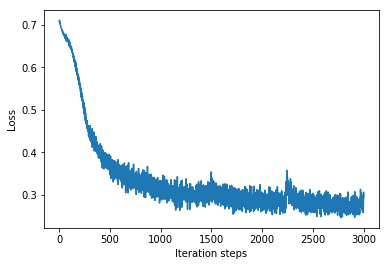

In [12]:
plt.plot(valid_loss_vec)
plt.xlabel('Iteration steps')
plt.ylabel('Loss');

min_idx = np.argmin(valid_loss_vec)
min_loss = np.min(valid_loss_vec)

print('Minimum at {}: {}'.format(min_idx, min_loss))

In [ ]:
np.save('valid_loss_8trellis_epochs', valid_loss_vec)

In [ ]:
valid_loss_vec = np.load('valid_loss_8trellis_epochs.npy').tolist()

## Load trained parameters

In [35]:
# model.load_state_dict(torch.load('../models/mb_ballroom_bs-100_fold-0.pt', map_location=device))